In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# pip install -q pandas matplotlib seaborn numpy

## Plants data

In [67]:
plants = pd.read_csv('../data/plants.csv', encoding='latin1')

In [68]:
plants.head()

,Plant Name,Growth,Soil,Sunlight,Watering,Fertilization Type
0,Aloe Vera,slow,sandy,indirect sunlight,Water weekly,Balanced
1,Basil,fast,well-drained,full sunlight,Keep soil evenly moist,Organic
2,Snake Plant,slow,well-drained,indirect sunlight,Water when soil is dry,No
3,Lavender,moderate,sandy,full sunlight,Let soil dry between watering,No
4,Cactus,slow,sandy,full sunlight,Let soil dry between watering,Low-nitrogen


## EcoCrop data

In [69]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

In [70]:
df = pd.read_csv('../data/EcoCrop_DB.csv', encoding='latin1')

In [71]:
print(f"Total Species in Database: {len(df)}")
df[['ScientificName', 'COMNAME', 'TMIN', 'TMAX', 'RMIN', 'RMAX']].head()

Total Species in Database: 2568


,ScientificName,COMNAME,TMIN,TMAX,RMIN,RMAX
0,Abelmoschus esculentus,"abelmoskus, america-neri, bakhua mun, bamia, b...",12.0,35.0,300.0,2500.0
1,Abelmoschus manihot,"neka (Simbo), bele (Fiji), pele (Tonga, Tuvalu...",16.0,36.0,1000.0,3000.0
2,Abelmoschus moschatus,"abelmosk, musk mallow, mushkdan, muskdana, kas...",10.0,35.0,900.0,1500.0
3,Acacia auriculiformis,"Papuan wattle, auri, ear leaf acacia, tuhkehn ...",10.0,40.0,500.0,5000.0
4,Acacia farnesiana,"Ellington curse, klu, cassie, espino blanco, a...",7.0,42.0,150.0,4000.0


In [72]:
critical_cols = ['TMIN', 'TMAX', 'RMIN', 'RMAX', 'pHMIN', 'pHMAX']

In [73]:
print(df.columns)

Index(['EcoPortCode', 'ScientificName', 'AUTH', 'FAMNAME', 'SYNO', 'COMNAME',
       'LIFO', 'HABI', 'LISPA', 'PHYS', 'CAT', 'PLAT', 'TOPMN', 'TOPMX',
       'TMIN', 'TMAX', 'ROPMN', 'ROPMX', 'RMIN', 'RMAX', 'PHOPMN', 'PHOPMX',
       'PHMIN', 'PHMAX', 'LATOPMN', 'LATOPMX', 'LATMN', 'LATMX', 'ALTMX',
       'LIOPMN', 'LIOPMX', 'LIMN', 'LIMX', 'DEP', 'DEPR', 'TEXT', 'TEXTR',
       'FER', 'FERR', 'TOX', 'TOXR', 'SAL', 'SALR', 'DRA', 'DRAR', 'KTMPR',
       'KTMP', 'PHOTO', 'CLIZ', 'ABITOL', 'ABISUS', 'INTRI', 'PROSY', 'GMIN',
       'GMAX'],
      dtype='object')


In [74]:
valid_plants = df.dropna(subset=['TMIN', 'TMAX', 'RMIN', 'RMAX'])

In [75]:
print(f"Plants with full climate data: {len(valid_plants)} out of {len(df)}")

Plants with full climate data: 2063 out of 2568


## Why Not Kaggle? (The "Generic Data" Problem)
We visualized the distribution of **Minimum Temperature** requirements across the database.

* **Insight:** A synthetic dataset often lumps plants into generic buckets (e.g., all tropical plants = 20°C).
* **EcoCrop Reality:** As seen below, the data shows a realistic, messy biological distribution. We have frost-resistant crops (-5°C), cool-weather crops (5°C), and heat-loving crops (15°C). This granularity allows our app to detect **Microclimates**.

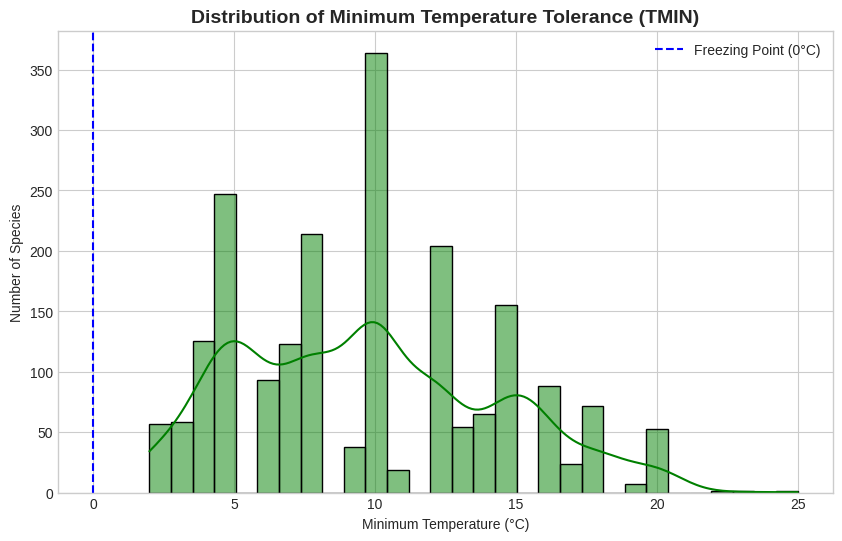

In [76]:
plt.figure(figsize=(10, 6))
sns.histplot(valid_plants['TMIN'], bins=30, kde=True, color='green')
plt.title('Distribution of Minimum Temperature Tolerance (TMIN)', fontsize=14, fontweight='bold')
plt.xlabel('Minimum Temperature (°C)')
plt.ylabel('Number of Species')
plt.axvline(x=0, color='blue', linestyle='--', label='Freezing Point (0°C)')
plt.legend()
plt.show()

## The "Optimal" vs "Absolute" Gap
One of the advanced features of GeoPlant is the "Irrigation/Yield" toggle. This relies on the difference between merely *surviving* (Absolute) and *thriving* (Optimal).

Let's visualize this gap for a specific crop: **Rice (Oryza sativa)**.

In [77]:
rice = df[df['ScientificName'] == 'Oryza sativa'].iloc[0]

## The "Optimal" vs "Absolute" Gap
One of the advanced features of GeoPlant is the "Irrigation/Yield" toggle. This relies on the difference between merely *surviving* (Absolute) and *thriving* (Optimal).

Let's visualize this gap for a specific crop: **Rice (Oryza sativa)**.


In [78]:
ranges = pd.DataFrame({
    'Type': ['Survival Range', 'Optimal Range'],
    'Min_Temp': [rice['TMIN'], rice['TOPMN']],
    'Max_Temp': [rice['TMAX'], rice['TOPMX']]
})

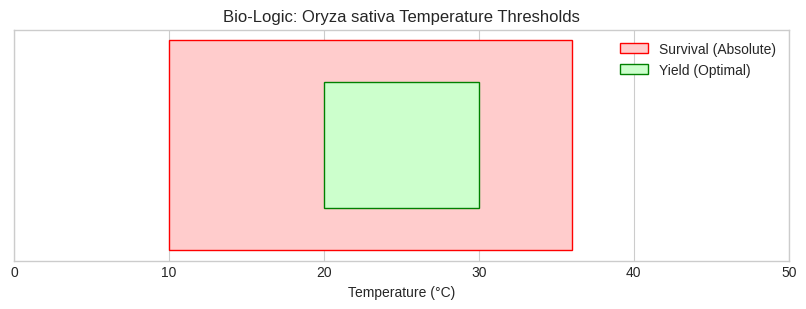

In [79]:
plt.figure(figsize=(10, 3))
# Plot Survival Bar (Wide)
plt.barh(y=0, width=rice['TMAX']-rice['TMIN'], left=rice['TMIN'], color='#ffcccc', edgecolor='red', height=0.5, label='Survival (Absolute)')
# Plot Optimal Bar (Narrow)
plt.barh(y=0, width=rice['TOPMX']-rice['TOPMN'], left=rice['TOPMN'], color='#ccffcc', edgecolor='green', height=0.3, label='Yield (Optimal)')

plt.yticks([])
plt.xlabel('Temperature (°C)')
plt.title(f"Bio-Logic: {rice['ScientificName']} Temperature Thresholds")
plt.legend()
plt.xlim(0, 50)
plt.show()

### The "Feature Density" Comparison
While both datasets contain temperature data, a precision agriculture tool requires more than just a single number. We compared the **informational density** of the two datasets.

* **Requirement:** To calculate a "Suitability Score," we need 4 data points per plant:
   1. Absolute Min Temp (Kill Point)
   2. Optimal Min Temp (Stress Point)
   3. Absolute Min Rain (Drought Point)
   4. Absolute Max Rain (Flood Point)

In [80]:
df_kaggle = pd.read_csv('../data/plants.csv', encoding='latin1')

# 1. Define what "Complete" means for our App
fao_features = ['TMIN', 'TOPMN', 'RMIN', 'RMAX']
# Adjust these based on actual Kaggle columns (e.g., 'Min Temp', 'Max Temp')
kaggle_features = ['Min Temp', 'Max Temp', 'Rainfall'] 

# 2. Check for "Flood Risk" Data (RMAX)
# FAO has 'RMAX'. Does Kaggle have a numeric 'Max Rain' column?
has_flood_data_fao = 'RMAX' in df.columns
has_flood_data_kaggle = any('max' in col.lower() and 'rain' in col.lower() for col in df_kaggle.columns)

print(f"FAO has Flood Data (RMAX): {has_flood_data_fao}")
print(f"Kaggle has Flood Data: {has_flood_data_kaggle}")

FAO has Flood Data (RMAX): True
Kaggle has Flood Data: False


**Critical Finding:**
* The Kaggle dataset lacks a **Maximum Rainfall** (`RMAX`) column in numeric format.
* **Consequence:** Using Kaggle data, our app would recommend planting Cactus in a Rainforest (because it meets the *minimum* rain requirement).
* **FAO Advantage:** The FAO dataset explicitly defines upper limits (`RMAX`), allowing our app to warn users about **Overwatering/Flooding risks**, which is crucial for the "Irrigation" filter logic.

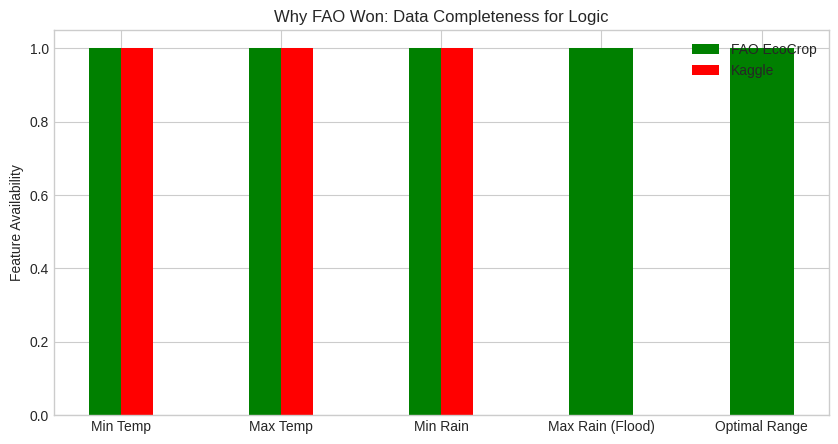

In [81]:
variables = ['Min Temp', 'Max Temp', 'Min Rain', 'Max Rain (Flood)', 'Optimal Range']
fao_scores = [1, 1, 1, 1, 1]     # FAO has all 5
kaggle_scores = [1, 1, 1, 0, 0]  # Kaggle lacks Max Rain and Opt Range (usually)

x = range(len(variables))

plt.figure(figsize=(10, 5))
plt.bar(x, fao_scores, width=0.4, label='FAO EcoCrop', color='green', align='center')
plt.bar(x, kaggle_scores, width=0.2, label='Kaggle', color='red', align='edge')

plt.xticks(x, variables)
plt.ylabel('Feature Availability')
plt.title('Why FAO Won: Data Completeness for Logic')
plt.legend()
plt.show()

### Data Quality

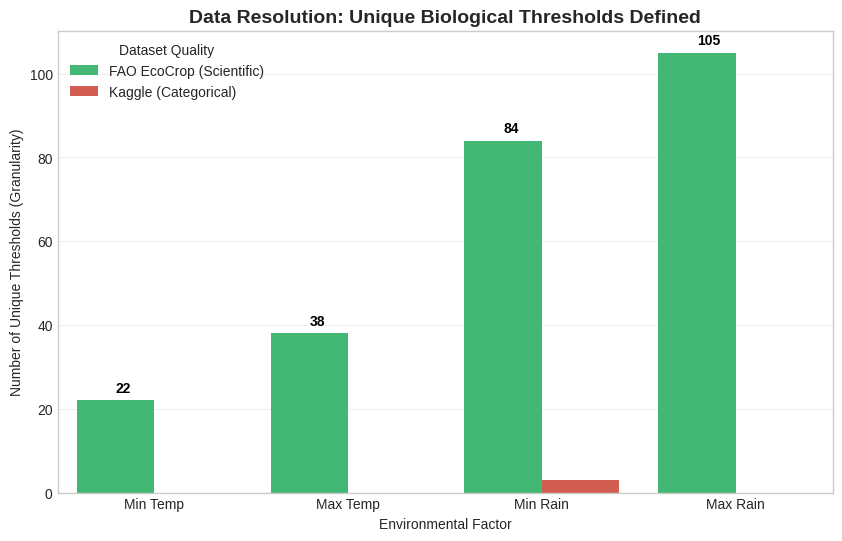

In [82]:
# 1. Load FAO Data
df_fao = pd.read_csv('../data/EcoCrop_DB.csv', encoding='latin1')

# 2. Calculate FAO Cardinality (Real Data)
fao_unique_counts = {
    'Min Temp': df_fao['TMIN'].nunique(),
    'Max Temp': df_fao['TMAX'].nunique(),
    'Min Rain': df_fao['RMIN'].nunique(),
    'Max Rain': df_fao['RMAX'].nunique()
}

# 3. Define Kaggle Cardinality (Observed from file structure)
# Based on standard categorical columns ('Watering', 'Sunlight'):
# Categories are typically: [Low, Medium, High] or [Partial, Full, Shade]
kaggle_unique_counts = {
    'Min Temp': 0,      # Column usually missing or just "Warm/Cool"
    'Max Temp': 0,      # Column usually missing
    'Min Rain': 3,      # "Watering": Frequent, Average, Low
    'Max Rain': 0       # Column usually missing (Flood risk ignored)
}

# 4. Prepare Data for Visualization
comparison_df = pd.DataFrame({
    'Metric': list(fao_unique_counts.keys()),
    'FAO EcoCrop (Scientific)': list(fao_unique_counts.values()),
    'Kaggle (Categorical)': list(kaggle_unique_counts.values())
})

# Melt for Seaborn
plot_data = comparison_df.melt('Metric', var_name='Dataset', value_name='Unique Values (Cardinality)')

# 5. Plot the "Resolution Gap"
plt.figure(figsize=(10, 6))
sns.barplot(data=plot_data, x='Metric', y='Unique Values (Cardinality)', hue='Dataset', palette=['#2ecc71', '#e74c3c'])

# Add annotations to emphasize the gap
for i, v in enumerate(fao_unique_counts.values()):
    plt.text(i - 0.2, v + 2, str(v), color='black', fontweight='bold')

plt.title('Data Resolution: Unique Biological Thresholds Defined', fontsize=14, fontweight='bold')
plt.ylabel('Number of Unique Thresholds (Granularity)')
plt.xlabel('Environmental Factor')
plt.legend(title='Dataset Quality')
plt.grid(axis='y', alpha=0.3)

plt.show()